### In this analysis, we will predict which passengers will survive from the singking of the Titanic

The type of machine learning we will be doing is called **classification**, because when we make predictions we are classifying each passenger as survived or not. 

More specifically, we are performing **binary classification**, which means that there are only two different states we are classifying.

# Exploring the Titanic Dataset

Kaggle provides datasets into two groups:
- training set (train.csv), which is used to build machine learning models.
- test set (test.csv), which is used to see how well our model performs on unseen data.

### Data dictionary:
- `PassengerID` - A column added by Kaggle to identify each row and make submissions easier
- `Survived` - Whether the passenger survived or not and the value we are predicting (0=No, 1=Yes)
- `Pclass` - The class of the ticket the passenger purchased (1=1st, 2=2nd, 3=3rd)
- `Sex` - The passenger's sex
- `Age` - The passenger's age in years
- `SibSp` - The number of siblings or spouses the passenger had aboard the Titanic
- `Parch` - The number of parents or children the passenger had aboard the Titanic
- `Ticket` - The passenger's ticket number
- `Fare` - The fare the passenger paid
- `Cabin` - The passenger's cabin number
- `Embarked` - The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton)

In [457]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import cross_val_score # cross validation
from sklearn.metrics import accuracy_score # score accuracy
from sklearn.linear_model import LogisticRegression # machine learning modeling
from sklearn.preprocessing import minmax_scale # data scaling
from sklearn.feature_selection import RFECV # feature selection
from sklearn.ensemble import RandomForestClassifier # machine learning modeling
from sklearn.model_selection import GridSearchCV # Hyperparameter Tuning
from sklearn.neighbors import KNeighborsClassifier # machine learning modeling

test = pd.read_csv("test.csv")
test_shape = test.shape

train = pd.read_csv("train.csv")
train_shape = train.shape

print(test_shape)
print(train_shape)

(418, 11)
(891, 12)


In [458]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


If you watched Titanic movie, you would remember that women and children were given preferences to lifeboats. Also, there was the vast class of disparity of passengers. This indicates that `Age`, `Sex`, and `Pclass` may be good predictors of survival. 

So, we'll start by exploring `Sex` and `Pclass` by visualizing the data.

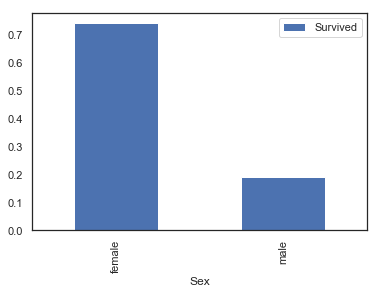

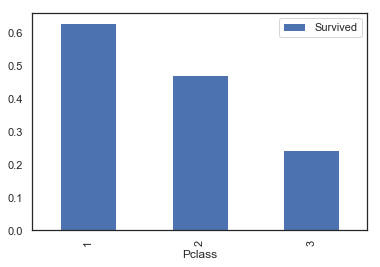

In [459]:
import matplotlib.pyplot as plt

sex_pivot = train.pivot_table(index="Sex",values="Survived")
sex_pivot.plot.bar()

class_pivot = train.pivot_table(index="Pclass", values="Survived")
class_pivot.plot.bar()
plt.show()

### Let's take a look at the `Age` columns

In [460]:
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

The `Age` column contains numbers ranging from `0.42` to `80.0` (`Age` is fractional if the passenger is less than one). Another thing to note is that there are 714 values in `Age` column, which is fewer than the 891 rows from what we discovered in the `train` dataset earlier. This indicates we have some missing values. This means that the `Age` column needs to be treated slightly differently.

### Let's look at distribution of `Age` and compare those survived vs died across different age ranges

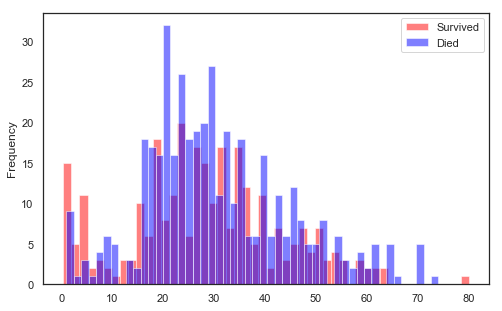

In [461]:
plt.figure(figsize=(8,5))

survived = train[train["Survived"] == 1]
died = train[train["Survived"] == 0]

survived["Age"].plot.hist(alpha=0.5,color='red',bins=50)
died["Age"].plot.hist(alpha=0.5,color='blue',bins=50)

plt.legend(['Survived','Died'])
plt.show()

The relationship here is not simple, but we can see that in some age ranges more passengers survived - where the red bars are higher than the blue bars.

In order for this to be useful to our machine learning model, we can separate this continuous feature into a categorical feature by dividing it into ranges. 

So, we will split the `Age` column into six categories:
- `Missing` from `-1` to `0`
- `Infant` from `0` to `5`
- `Child` from `5` to `12`
- `Teenager` from `12` to `18`
- `Young Adult` from `18` to `35`
- `Adult` from `35` to `60`
- `Senior` from `60` to `100`


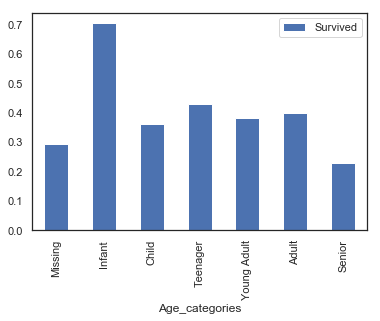

In [462]:
# Create new column called `Age_categories` to categorize age range into specific group
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df


cut_points = [-1,0,5,12,18,35,60,100]
label_names = ["Missing", "Infant", "Child", "Teenager", "Young Adult", "Adult", "Senior"]

# Apply the categorization to both train and test dataset
train = process_age(train, cut_points, label_names)
test = process_age(test, cut_points, label_names)

#
age_pivot = train.pivot_table(index="Age_categories", values="Survived")
age_pivot.plot.bar()
plt.show()

# Preparing our Data for Machine Learning

let's create a function to create the dummy columns for text labels, nominal labels and add them back to the original dataframe.



In [463]:
def create_dummies(df, column_name):
    dummies = pd.get_dummies(df[column_name], prefix=column_name)
    df = pd.concat([df, dummies], axis=1)
    return df

In [464]:
# Let's apply the create_dummies function to `Sex` and `Pclass` columns

train = create_dummies(train,"Pclass")
test = create_dummies(test,"Pclass")

train = create_dummies(train, "Sex")
test = create_dummies(test, "Sex")

train = create_dummies(train, "Age_categories")
test = create_dummies(test, "Age_categories")


In [465]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Pclass_3,Sex_female,Sex_male,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,1,0,1,0,0,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,1,0,0,0,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,1,1,0,0,0,0,0,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,1,0,0,0,0,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,1,0,1,0,0,0,0,1,0,0


# Creating our First Machine Learning Model

The first model we will used is **Logistic Regression** using Scikit-Learn library. And we will split out `train` dataset into train and holdout data using `model_selection.train_test_split()`

In [466]:
# from now on we will refer to this
# dataframe as the holdout data
holdout = test 

from sklearn.model_selection import train_test_split

columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

train_X, test_X, train_y, test_y = train_test_split(train[columns],
                                                    train["Survived"],
                                                    test_size=0.2,
                                                    random_state=0)

### Making predictions and measuring their accuracy

In [467]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train_X, train_y)
predictions = lr.predict(test_X)
accuracy = accuracy_score(test_y, predictions)
print(accuracy)

0.8100558659217877


Since this dataset is quite small, there is a good chance that our model is overfitting and will not perform well on the unseen data.

So we will use a technique called **cross validation** to train and test our model on different splits of our data, and then average the accuracy scores.

In [468]:
from sklearn.model_selection import cross_val_score
import numpy as np

all_X = train[columns]
all_y = train["Survived"]

lr = LogisticRegression()

scores = cross_val_score(lr, all_X, all_y, cv=10)

accuracy = np.mean(scores)

print(scores)
print('average accuracy: ',accuracy)

[0.8        0.81111111 0.7752809  0.87640449 0.80898876 0.78651685
 0.76404494 0.76404494 0.83146067 0.80681818]
average accuracy:  0.8024670865963002


### Making Predictions on Unseen Data

In [469]:
columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

lr = LogisticRegression()
lr.fit(all_X, all_y)
holdout_predictions = lr.predict(holdout[columns])


### Creating the First Submission File

In [470]:
holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv("submission.csv", index=False)

# Let's Boost the Accuracy of our Predictions 
### by Feature Preparation, Selection and Engineering

First, we can ignore `PassengerId` as it's used to identify each passenger and `Survived` as it is what we're predicting, as well as the three columns we've already used (`Pclass`, `Sex`, and `Age`).

Here is a list of the remaining columns: `SibSp`, `Parch`, `Ticket`, `Fare`, `Cabin`, and `Embarked`. Let's explore to these columns to give us some more information on the values.


In [471]:
columns = ['SibSp','Parch','Fare','Cabin','Embarked']
print(train[columns].describe(include='all',percentiles=[]))

             SibSp       Parch        Fare Cabin Embarked
count   891.000000  891.000000  891.000000   204      889
unique         NaN         NaN         NaN   147        3
top            NaN         NaN         NaN    G6        S
freq           NaN         NaN         NaN     4      644
mean      0.523008    0.381594   32.204208   NaN      NaN
std       1.102743    0.806057   49.693429   NaN      NaN
min       0.000000    0.000000    0.000000   NaN      NaN
50%       0.000000    0.000000   14.454200   NaN      NaN
max       8.000000    6.000000  512.329200   NaN      NaN


- `SibSp`, `Parch`, `and `Fare` look to be standard numeric columns with no missing values.
- `Cabin` has values for only 204 of the 891 rows, and most of the values are unique.
- `Embarked` looks to be a standard categorical column with 3 unique values and it has just only two missing values. We can easily fill these missing values with the most common values, `"S"` which appears 644 times.




# Preparing More Features

Regarding the numeric columns, since there is a big difference between the range of each, so we will need to rescale the data. 

And we will create dummy columns from `Embarked` column

In [472]:
from sklearn.preprocessing import minmax_scale
# The holdout set has a missing value in the Fare column which
# we'll fill with the mean.
holdout["Fare"] = holdout["Fare"].fillna(train["Fare"].mean())
columns = ["SibSp","Parch","Fare"]

train["Embarked"] = train["Embarked"].fillna("S")
holdout["Embarked"] = holdout["Embarked"].fillna("S")

train = create_dummies(train,"Embarked")
holdout = create_dummies(holdout,"Embarked")

for col in columns:
    train[col + "_scaled"] = minmax_scale(train[col])
    holdout[col + "_scaled"] = minmax_scale(holdout[col])

c:\python36\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
c:\python36\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
c:\python36\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
c:\python36\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


In [473]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior,Embarked_C,Embarked_Q,Embarked_S,SibSp_scaled,Parch_scaled,Fare_scaled
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,1,0,0,0,0,1,0.125,0.0,0.014151
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,1,0,1,0,0,0.125,0.0,0.139136
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,1,0,0,0,0,1,0.000,0.0,0.015469
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,1,0,0,0,0,1,0.125,0.0,0.103644
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,1,0,0,0,0,1,0.000,0.0,0.015713


# Determining the Most Relevant Features

Let's select the best-performing features by training with machine learning model with all of our features and look at the coefficients of each feature.

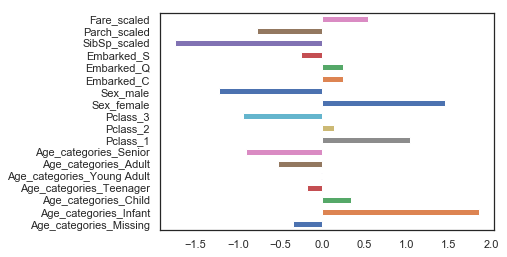

In [474]:
columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled']

lr = LogisticRegression()
lr.fit(train[columns], train["Survived"])
coefficients = lr.coef_

feature_importance = pd.Series(coefficients[0], index=train[columns].columns)
feature_importance.plot.barh()
plt.show()

To make things easier to interpret, we'll alter the plot to show all positive values, and have sorted the bars in order of size.

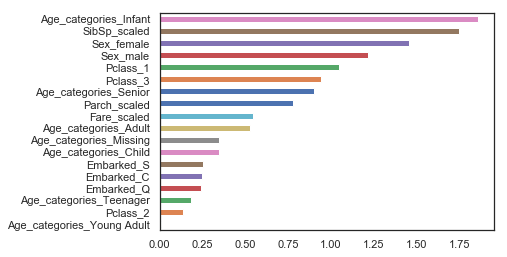

In [475]:
ordered_feature_importance = feature_importance.abs().sort_values()
ordered_feature_importance.plot.barh()
plt.show()

# Training a model using Relevant Features

We'll train a new model with the top 8 scores from the previous plot we generated and check our accuracy using cross validation.

In [476]:
columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']

lr = LogisticRegression()

scores = cross_val_score(lr, train[columns], train["Survived"], cv=10)

accuracy = scores.mean()

print(accuracy)


0.8148019521053229


### Engineering New Features

Let's look at histograms of the `Fare` column for passengers who died and survived, and see if there are patterns that we can use when creating our bins.

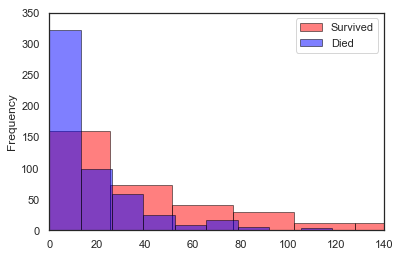

In [477]:

survived = train[train["Survived"] == 1]
died = train[train["Survived"] == 0]

survived["Fare"].plot.hist(alpha=0.5,color='red', edgecolor='black', bins=20, ylim=(0,350), xlim=(0,140))
died["Fare"].plot.hist(alpha=0.5,color='blue', edgecolor='black',bins=20, ylim=(0,350), xlim=(0,140))

plt.legend(['Survived','Died'])
plt.show()

Looking at the values, it looks like we can separate the feature into four bins to capture some patterns from the data:

- 0-12
- 12-50
- 50-100
- 100+

In [478]:
def process_fare(df,cut_points,label_names):
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

cut_points = [0,12,50,100,1000]
label_names = ["0-12", "12-50", "50-100", "100+"]
train = process_fare(train, cut_points, label_names)
holdout = process_fare(holdout, cut_points, label_names)

train = create_dummies(train, "Fare_categories")
holdout = create_dummies(holdout, "Fare_categories")

### Engineering Features from Text Columns

Earlier, we didn't used `Name` and `Cabin` in our analysis, but what if there is some data where we could extract? Let's take a look at a random sample of rows from those two columns.

In [479]:
train[pd.notnull(train["Cabin"])][["Name", "Cabin"]].sample(10)

,Name,Cabin
394,"Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengt...",G6
185,"Rood, Mr. Hugh Roscoe",A32
515,"Walker, Mr. William Anderson",D46
710,"Mayne, Mlle. Berthe Antonine (""Mrs de Villiers"")",C90
867,"Roebling, Mr. Washington Augustus II",A24
581,"Thayer, Mrs. John Borland (Marian Longstreth M...",C68
284,"Smith, Mr. Richard William",A19
715,"Soholt, Mr. Peter Andreas Lauritz Andersen",F G73
329,"Hippach, Miss. Jean Gertrude",B18
781,"Dick, Mrs. Albert Adrian (Vera Gillespie)",B20


For `Cabin`, it seems like the format of the cabin numbers is one letter followed by two numbers and the letter represents the type of cabin, which could be usedful data for us.

As for `Name`, there is a title like 'Mr' or 'Mrs' within each.

So, let's simplify category of titles and create dummy columns to those categories.

In [480]:
titles = {
    "Don":         "Mr",
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Countess":    "Miss",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Sir" :        "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}

extracted_titles = train["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
train["Title"] = extracted_titles.map(titles)
extracted_titles = holdout["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
holdout["Title"] = extracted_titles.map(titles)

train["Cabin_type"] = train["Cabin"].str[0]
train["Cabin_type"] =train["Cabin_type"].fillna("Unknown")

holdout["Cabin_type"] = holdout["Cabin"].str[0]
holdout["Cabin_type"] = holdout["Cabin_type"].fillna("Unknown")

train = create_dummies(train, "Title")
holdout = create_dummies(holdout, "Title")

train = create_dummies(train, "Cabin_type")
holdout = create_dummies(holdout, "Cabin_type")


In [497]:
train.head()

,PassengerId,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,...,Title_Royalty,Cabin_type_A,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown
0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,3,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,1,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,5,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


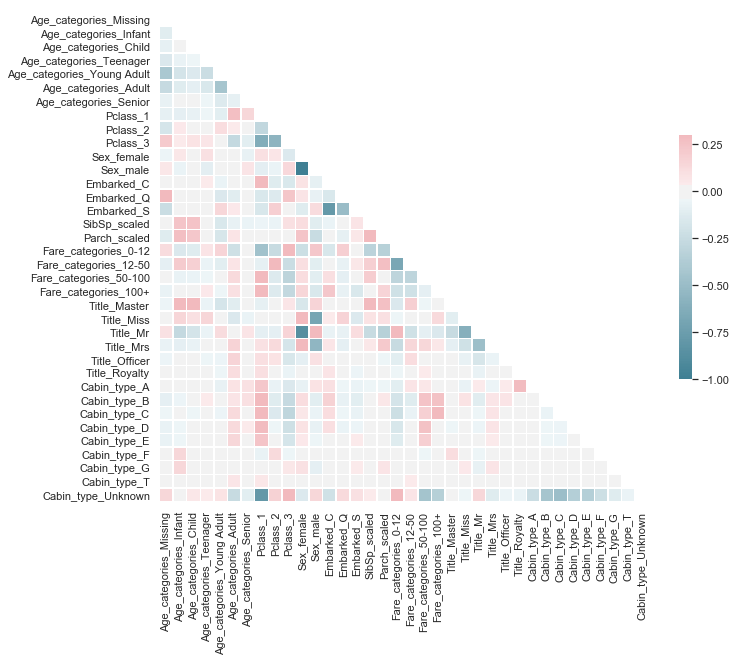

In [482]:
import numpy as np
import seaborn as sns

def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_categories_0-12',
       'Fare_categories_12-50','Fare_categories_50-100', 'Fare_categories_100+',
       'Title_Master', 'Title_Miss', 'Title_Mr','Title_Mrs', 'Title_Officer',
       'Title_Royalty', 'Cabin_type_A','Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
       'Cabin_type_E','Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown']

plot_correlation_heatmap(train[columns])

We can see that there is a high correlation between `Sex_female`/`Sex_male` and `Title_Miss`/`Title_Mr`/`Title_Mrs`. We will remove the columns `Sex_female` and `Sex_male` since the title data may be more nuanced.

Apart from that, we should remove one of each of our dummy variables to reduce the collinearity in each. We'll remove:
- `Pclass_2`
- `Age_categories_Teenager`
- `Fare_categories_12-50`
- `Title_Master`
- `Cabin_type_A`

# Final Feature Selection using RFECV

In [483]:
from sklearn.feature_selection import RFECV

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Pclass_1', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'SibSp_scaled',
       'Parch_scaled', 'Fare_categories_0-12', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown']

all_X = train[columns]
all_y = train["Survived"]


lr = LogisticRegression()
selector = RFECV(lr, cv=10)
selector.fit(all_X, all_y)

optimized_columns = all_X.columns[selector.support_]

# Training A Model Using our Optimized Columns

In [484]:
all_X = train[optimized_columns]
all_y = train["Survived"]

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)

accuracy = scores.mean()
print(accuracy)

0.8238664737260244


In [487]:
columns = ['Name', 'Ticket', 'Embarked', 'Parch', 'Pclass',
           'Cabin', 'Sex', 'Cabin_type', 'Title', 'Age_categories', 
           'Age', 'Fare_categories', 'Fare', 'SibSp']

train = train.drop(columns, axis=1)

holdout = holdout.drop(columns, axis=1)
holdout['Cabin_type_T'] = 0

In [488]:
holdout.head()

,PassengerId,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,...,Title_Royalty,Cabin_type_A,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_Unknown,Cabin_type_T
0,892,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,893,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,894,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,895,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,896,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [489]:
holdout2.head()

,PassengerId,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior,Pclass_1,Pclass_2,...,Title_Royalty,Cabin_type_A,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown
0,892,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,893,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,894,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
3,895,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,896,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# Training a Model using K-Nearest Neighbors

In [490]:
from sklearn.neighbors import KNeighborsClassifier

all_X = train.drop(['Survived','PassengerId'],axis=1)
all_y = train['Survived']

knn = KNeighborsClassifier(n_neighbors=1)

scores = cross_val_score(knn, all_X, all_y, cv=10)

accuracy_knn = scores.mean()

print(accuracy_knn)

0.7846144024514812


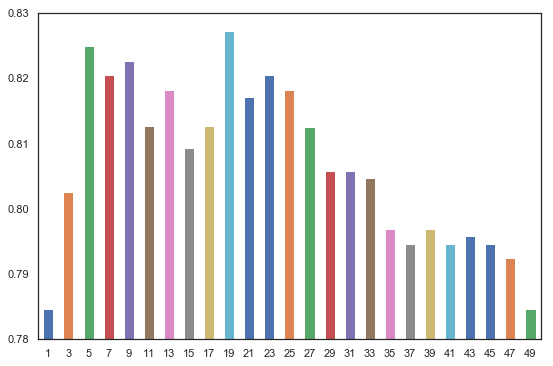

In [491]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_dict(dictionary):
    pd.Series(dictionary).plot.bar(figsize=(9,6),
                                   ylim=(0.78,0.83),rot=0)
    plt.show()

knn_scores = dict()
for k in range(1,50,2):
    knn = KNeighborsClassifier(n_neighbors=k)

    scores = cross_val_score(knn, all_X, all_y, cv=10)
    accuracy_knn = scores.mean()
    knn_scores[k] = accuracy_knn

plot_dict(knn_scores)

Looking at our plot from the previous screen we can see that a k value of 19 gave us our best score.

In [492]:
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()

hyperparameters = {
    "n_neighbors": range(1,50,2)
}
grid = GridSearchCV(knn, param_grid=hyperparameters, cv=10)
grid.fit(all_X, all_y)

print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 19}
0.8271604938271605


In [493]:
holdout_no_id = holdout.drop(['PassengerId'],axis=1)
best_knn = grid.best_estimator_

holdout_predictions = best_knn.predict(holdout_no_id)

submission_df = {"PassengerId": holdout["PassengerId"],
                 "Survived": holdout_predictions}

submission = pd.DataFrame(submission_df)
submission.to_csv("submission_knn.csv", index=False)

# Automating Hyperparameter Optimization with Grid Search

In [494]:
from sklearn.model_selection import GridSearchCV

hyperparameters = {
    "n_neighbors": range(1,20,2),
    "weights": ["distance", "uniform"],
    "algorithm": ['brute'],
    "p": [1,2]
}

grid = GridSearchCV(knn, param_grid=hyperparameters, cv=10)
grid.fit(all_X, all_y)

best_params = grid.best_params_
best_score = grid.best_score_

print(best_params)
print(best_score)

{'algorithm': 'brute', 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
0.8294051627384961


# Training a Model using Random Forests with GridSearch

In [495]:
from sklearn.ensemble import RandomForestClassifier

hyperparameters = {
    "criterion": ["entropy", "gini"],
    "max_depth": [5, 10],
    "max_features": ["log2", "sqrt"],
    "min_samples_leaf": [1, 5],
    "min_samples_split": [3, 5],
    "n_estimators": [6,9]
}

clf = RandomForestClassifier(random_state=1)
grid = GridSearchCV(clf, param_grid=hyperparameters, cv=10)
grid.fit(all_X, all_y)

best_params = grid.best_params_
best_score = grid.best_score_

print(best_params)
print(best_score)

{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 9}
0.8406285072951739


In [496]:
best_rf = grid.best_estimator_
holdout_no_id = holdout.drop(['PassengerId'],axis=1)
holdout_predictions = best_rf.predict(holdout_no_id)

holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv("submission_rf1.csv",index=False)